In [1]:
import numpy as np
from itertools import product
from multiprocessing import Pool, cpu_count
from finite_tight_binding import TightBindingHamiltonian
import scipy.constants as spc

In [2]:
class EffectiveMass(TightBindingHamiltonian):
    def __init__(self, N, sparseSetting = False):
        super().__init__(N)
        self.sparse_setting = True
        
        # sparse parameter
        self.sigma = 0.55 # start values of eigenvalues
        self.eigenRange = 10 # amount of computed eigenvalues (initially 10)
        self.cbm = {}
        self.vbm = {}
        self.cbmValue = [0,np.inf]
        self.vbmValue = [0, -np.inf]
        self.Nk = 400
        self.a = 5.431e-10

        
    def make_mp_grid(self, Nk, centred=True):
        if centred:
            # symmetric points:  -½, -(½-1/Nk), …, +(½-1/Nk)
            half_step = 0.5 / Nk
            shifts = np.arange(-0.5, 0.5, 1.0 / Nk) + half_step
        else:
            # conventional Γ‑centred grid on [0,1)
            shifts = np.arange(Nk) / Nk

        klist = np.array(list(product(shifts, repeat=2)))  # shape (Nk**2, 2)
        return klist   
                                            
    # helper method 
    def frac_shift(self, k_frac, delta):
        return (k_frac + delta) #% 1.0
    def _sparse_eval(self, k, sigma, m):
        """Return eigenvalue array (sorted) for a given sigma and range m."""
        ev, _ = self.create_tight_binding_sparse(k, self.N,
                                                 sigma=sigma,
                                                 eigRange=m)
        return np.asarray(ev)
    
  
    def analyzeEnergyRange(self, k, energies=None, effectiveMassCalc=True,
                           max_iter=25, grow=5, σ_step=0.2):

        if energies is None:
            energies = self._sparse_eval(k, self.sigma, self.eigenRange)
       
        for _ in range(max_iter):

            has_pos = np.any(energies > 0)
            has_neg = np.any(energies < 0)
            if has_pos and has_neg:
                # collect extrema
                min_pos_idx = np.argmin(energies[energies > 0])
                max_neg_idx = np.argmax(energies[energies < 0])

                min_positive = energies[energies > 0][min_pos_idx]
                max_negative = energies[energies < 0][max_neg_idx]

                # bookeeping
                if not effectiveMassCalc:
                    self.cbm[tuple(k)] = [min_positive, self.sigma, self.eigenRange]
                    if min_positive < self.cbmValue[1]:
                        print(k, min_positive)
                        self.cbmValue = [k, min_positive]

                    self.vbm[tuple(k)] = [max_negative, self.sigma, self.eigenRange]
                    if max_negative > self.vbmValue[1]:        # less negative is “larger”
                        self.vbmValue = [k, max_negative]

                # --------- prepare next k‑point search ----------------------
                self.sigma = 0.5 * (min_positive + max_negative)
                self.eigenRange = 5                           # reset to a lean window

    
                if effectiveMassCalc:
               
                    return min_positive
                return min_positive, max_negative                             
            band_min, band_max = energies.min(), energies.max()

            
            # adaptive sigma
            if not has_pos:     
                self.sigma += max(σ_step, 0.5*abs(band_min))  
            elif not has_neg:   
                self.sigma -= max(σ_step, 0.5*abs(band_max))

            # widen the window a little every time we fail
            self.eigenRange += grow
            energies = self._sparse_eval(k, self.sigma, self.eigenRange)

        # ---------- could not bracket zero within max_iter -------------------
        print(f"[warn] unable to bracket E=0 at k={k} after {max_iter} trials")
        if effectiveMassCalc:
            return None          # caller must handle this case
        
    def getMinimum(self,k_frac):
        return self.analyzeEnergyRange(k_frac, effectiveMassCalc = True)
        
    def eval_k_sparse(self, k_frac, effMass = True):
        eigenvalues, H = self.create_tight_binding_sparse(np.array([0,0]), sigma=self.sigma, eigRange= self.eigenRange)
        self.analyzeEnergyRange(k_frac, eigenvalues, effectiveMassCalc = effMass)
    
    def determineInitialSparseSettings(self):
        k = np.array([0,0])
        eigenvalues, H = self.create_tight_binding_sparse(np.array([0,0]), sigma=self.sigma, eigRange= self.eigenRange)
        self.analyzeEnergyRange(k, eigenvalues)
    
    def scan_full_BZ(self, Nk=51, store_all=True, n_jobs=None, a=5.431e-10, res_factor=4):
        self.Nk = Nk
        klist = self.make_mp_grid(Nk)
        #print(klist)
        for k in klist:
            self.eval_k_sparse(k, effMass=False)
    
    def calculateEffectiveMass(self, startk = np.array([0,0]), resolution=4):
    
        def E(k_frac):
            evs = self.analyzeEnergyRange(k_frac,effectiveMassCalc=True)
            #print(evs, k_frac)
            return evs

        delta_frac = 1.0 / (self.Nk * resolution)
        dk = (2 * np.pi / self.a) * delta_frac

        k0 = np.asarray(startk, float)
        #print(f"this the min {E(k0)}")
        ei = np.eye(2)
        H = np.zeros((2,2))
        for i in range(2):
            # second derivative along axis i
            kp = self.frac_shift(k0,  +delta_frac * ei[i])
            km = self.frac_shift(k0,  -delta_frac * ei[i])
            H[i,i] = (E(kp) + E(km) - 2*E(k0)) / dk**2

            # mixed derivatives
            for j in range(i+1, 2):
                kpp = self.frac_shift(k0, +delta_frac*ei[i] + delta_frac*ei[j])
                kmm = self.frac_shift(k0, -delta_frac*ei[i] - delta_frac*ei[j])
                kpm = self.frac_shift(k0, +delta_frac*ei[i] - delta_frac*ei[j])
                kmp = self.frac_shift(k0, -delta_frac*ei[i] + delta_frac*ei[j])
                H[i,j] = H[j,i] = (E(kpp)+E(kmm)-E(kpm)-E(kmp)) / (4*dk**2)

        H_J = H * spc.e
        mstar_SI = spc.hbar**2 * np.linalg.inv(H_J)
        mstar_me = mstar_SI / spc.m_e
        eigvals, eigvecs = np.linalg.eigh(mstar_me)  
        principal_masses = eigvals       

        return principal_masses

        

In [3]:
effectiveMass = EffectiveMass(2)
x = effectiveMass.getMinimum(k_frac=np.array([0,0]))

In [4]:
effectiveMassData = [None] * 30

for i in range(1, 31):
    effectiveMass = EffectiveMass(i)
    m1,m2 = effectiveMass.calculateEffectiveMass(resolution = 4)

    effectiveMassData[i - 1] = (m1,m2)


[(np.float64(0.052396273195805886), np.float64(0.052396273198080594)), (np.float64(0.050270917852522586), np.float64(0.050270917853931105)), (np.float64(0.05068176458298962), np.float64(0.05068176458586715)), (np.float64(0.05086030428049004), np.float64(0.0508603042851978)), (np.float64(0.05042834778245068), np.float64(0.05042834778252155)), (np.float64(0.0504922985368494), np.float64(0.050492298544580184)), (np.float64(0.0505268889976472), np.float64(0.05052688900961663)), (np.float64(0.05038241628737408), np.float64(0.050382416288582865)), (np.float64(0.05041543266238119), np.float64(0.050415432663014716)), (np.float64(0.050350952615428955), np.float64(0.05035095277468648)), (np.float64(0.05035996671297638), np.float64(0.050359966715417495)), (np.float64(0.050378606608844405), np.float64(0.050378606646201744)), (np.float64(0.05033621833026958), np.float64(0.050336218544783824)), (np.float64(0.05034754528986265), np.float64(0.0503475452949566)), (np.float64(0.05035735041611558), np.fl

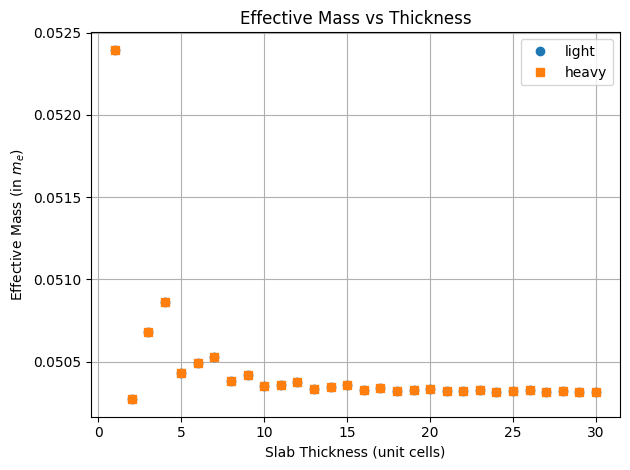

In [6]:
import numpy as np
import matplotlib.pyplot as plt
print(effectiveMassData)
m1 = np.array([val[0] for val in effectiveMassData])
m2 = np.array([val[-1] for val in effectiveMassData])
thickness = np.array([i for i in range (1,31)])

plt.figure()
plt.plot(thickness, m1, 'o', label='light')
plt.plot(thickness, m2, 's', label='heavy')
plt.xlabel('Slab Thickness (unit cells)')
plt.ylabel('Effective Mass (in $m_e$)')
plt.title('Effective Mass vs Thickness')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
